In [1]:
from ecnet.datasets import load_mon, QSPRDataset
from sklearn.model_selection import train_test_split

smiles, targets = load_mon()
smiles_train, smiles_test, targets_train, targets_test = train_test_split(
    smiles, targets, test_size=0.2, random_state=24
)
dataset_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
dataset_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([246, 5305]) torch.Size([62, 5305])


In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=dataset_train.desc_vals.shape[0], svd_solver='full')
pca.fit(dataset_train.desc_vals.detach().numpy())
total_var = 0.0
n_comp = 0
for vr in pca.explained_variance_ratio_:
    total_var += vr
    n_comp += 1
    if total_var >= 0.99:
        break
print(n_comp, total_var)
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(dataset_train.desc_vals.detach().numpy())
print(sum(pca.explained_variance_ratio_))

9 0.9918880364857614
0.9918880364857614


In [3]:
import torch

dataset_train.desc_vals = torch.from_numpy(pca.transform(
    dataset_train.desc_vals.detach().numpy()
))
dataset_test.desc_vals = torch.from_numpy(pca.transform(
    dataset_test.desc_vals.detach().numpy()
))
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([246, 9]) torch.Size([62, 9])


In [4]:
from ecnet import ECNet

model = ECNet(dataset_train.desc_vals.shape[1], 1, 128, dataset_train.target_vals.shape[1])

In [5]:
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.2, verbose=10,
    patience=100, epochs=1000, random_state=25,
    lr=0.01, lr_decay=1e-6, batch_size=48
)

Epoch: 0 | Train loss: 5763.942183514031 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 296.2042672293527 | Valid loss: 244.91824340820312
Epoch: 20 | Train loss: 161.0976061139788 | Valid loss: 234.5914306640625
Epoch: 30 | Train loss: 104.52578416162608 | Valid loss: 200.2772979736328
Epoch: 40 | Train loss: 94.51665372264628 | Valid loss: 196.29981994628906
Epoch: 50 | Train loss: 49.343486163080954 | Valid loss: 193.30455017089844
Epoch: 60 | Train loss: 72.99000362474091 | Valid loss: 198.08692932128906
Epoch: 70 | Train loss: 41.145935525699535 | Valid loss: 155.31723022460938
Epoch: 80 | Train loss: 50.700689043317524 | Valid loss: 205.63165283203125
Epoch: 90 | Train loss: 36.20746472417092 | Valid loss: 165.08273315429688
Epoch: 100 | Train loss: 55.07980658083546 | Valid loss: 255.37823486328125
Epoch: 110 | Train loss: 41.189600107621175 | Valid loss: 183.2620849609375
Epoch: 120 | Train loss: 37.55363711045713 | Valid loss: 203.6495361328125
Epoch: 130 | Train lo

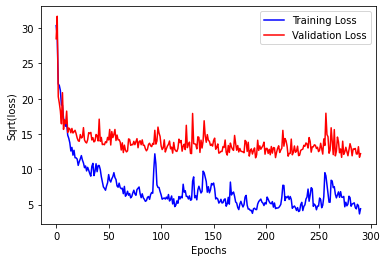

In [6]:
from math import sqrt
from matplotlib import pyplot as plt

train_loss = [sqrt(l) for l in train_loss][3:]
valid_loss = [sqrt(l) for l in valid_loss][3:]
epoch = [i for i in range(len(train_loss))]

plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Sqrt(loss)')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='red', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [7]:
from sklearn.metrics import median_absolute_error, r2_score

y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals
train_mae = median_absolute_error(y_hat_train, y_train)
train_r2 = r2_score(y_hat_train, y_train)
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals
test_mae = median_absolute_error(y_hat_test, y_test)
test_r2 = r2_score(y_hat_test, y_test)
print('Training median absolute error: {}'.format(train_mae))
print('Training r-squared coefficient: {}'.format(train_r2))
print('Testing median absolute error: {}'.format(test_mae))
print('Testing r-squared coefficient: {}'.format(test_r2))

Training median absolute error: 2.6379623413085938
Training r-squared coefficient: 0.8641966258555328
Testing median absolute error: 4.641395568847656
Testing r-squared coefficient: 0.7457224511684769


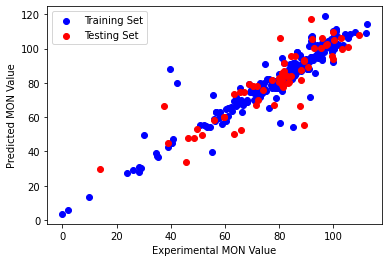

In [8]:
plt.clf()
plt.xlabel('Experimental MON Value')
plt.ylabel('Predicted MON Value')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()